In [52]:
import os
import pickle
from pprint import pprint
import datetime
import numpy as np
from matplotlib import pyplot as plt
import torch
from structure_utils import *
import pdb

dirname = 'test2'


In [53]:
# Display hyperparameters and run information

params = pickle.load(open(dirname+'/hyperparameters.pkl', 'rb'))
pprint(params)

runtime = pickle.load(open(dirname+'/runtime.pkl', 'rb'))
print('\nRuntime: ' + str(datetime.timedelta(seconds=runtime)))

{'alternate_every': 5,
 'batch_size': 3,
 'device': 'cpu',
 'embeddings': 'gensim',
 'epochs': 100,
 'epochs_per_checkpoint': 1,
 'initial_train_mode': 'weights',
 'lambdas': [1, 0, 1e-08, 0.003],
 'learning_rate': 0.0001,
 'loss2_margin': 1,
 'max_grad': 1,
 'multiplier': 1,
 'nb_train': 11,
 'nb_val': 10,
 'optimizer': 'adam',
 'pickle_every': 10,
 'pretrained_weights': False,
 'scoring_hidden_size': 64,
 'validate_every': 1,
 'warm_start': False,
 'weights_file': 'epoch_0.pt'}

Runtime: 0:02:21.091647


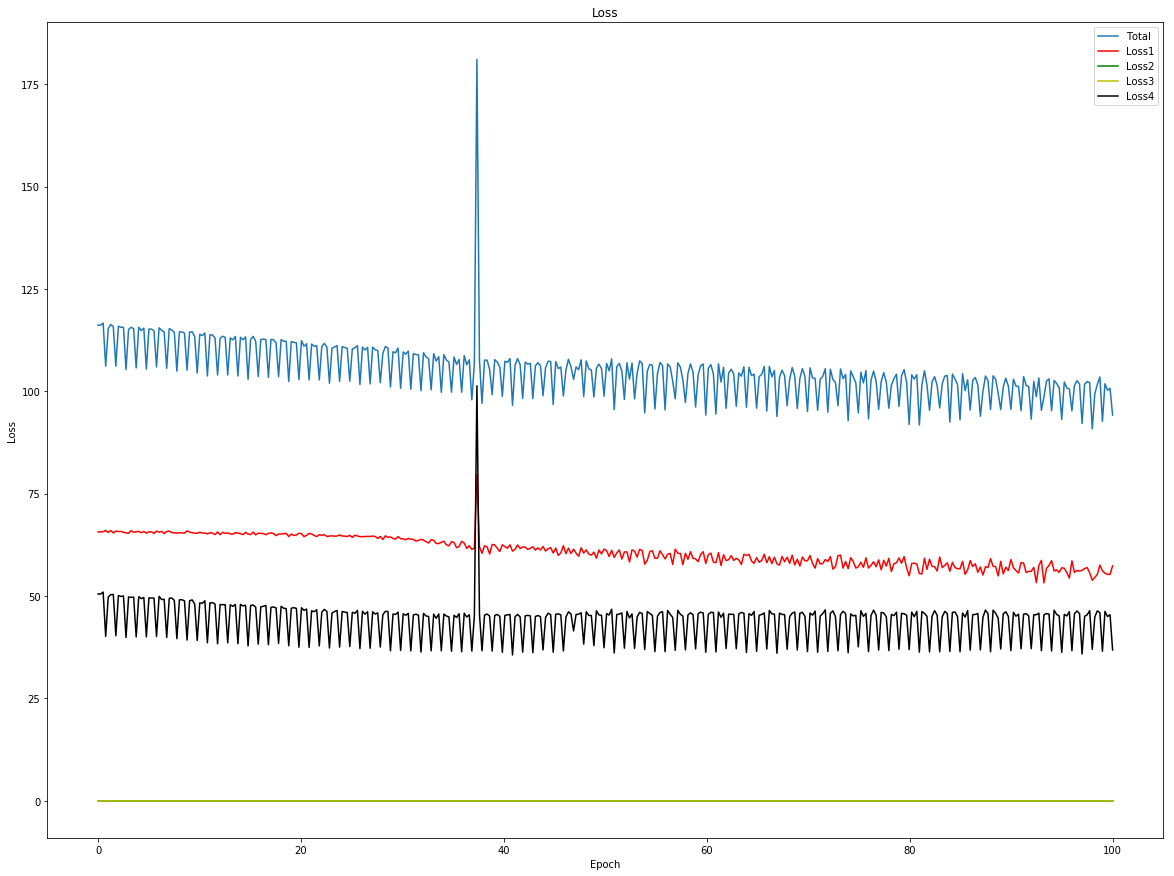

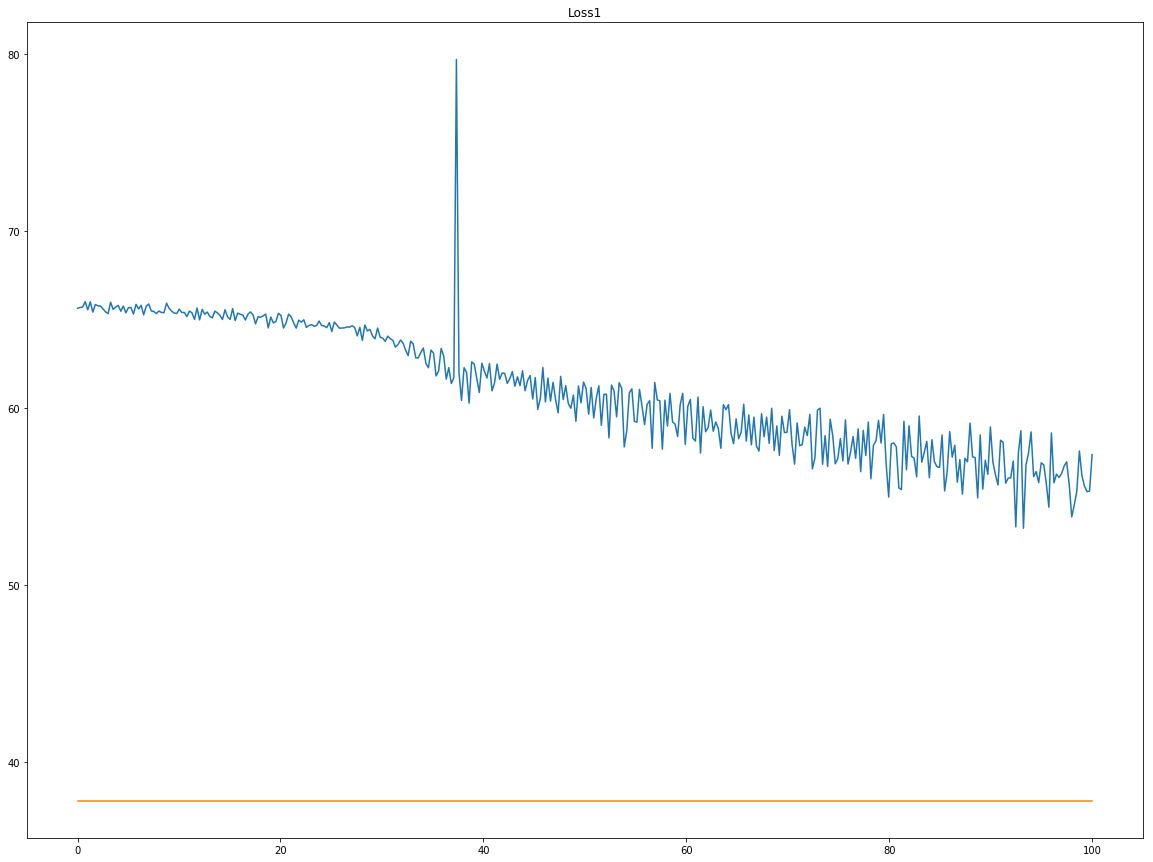

In [54]:
losses = pickle.load(open(dirname + '/loss_history.pkl', 'rb'))
losses = np.array(losses)
# losses[:, 0][losses[:, 0] < 30] *= 2
n_iters = losses.shape[0]
iters_per_epoch = params['nb_train'] // params['batch_size'] + 1
n_epochs = n_iters // iters_per_epoch
# x_axis = range(n_epochs * (params['nb_data'] // params['batch_size'] + 1))
x_axis = np.linspace(0, n_epochs, num=n_iters)

batch_size = params['batch_size']
# Plot total loss
plt.figure(figsize=(20, 15))
n_data = params['nb_train']
plt.plot(x_axis, np.sum(losses, axis=1), label='Total')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot respective losses
colors = ['r', 'g', 'y', 'k']
for i in range(4):
    plt.plot(x_axis, losses[:, i], colors[i], label='Loss' + str(i+1))

plt.legend(loc='upper right')
plt.show()

# Plot loss1 separately
plt.figure(figsize=(20, 15))
plt.title('Loss1')
plt.plot(x_axis, losses[:, 0])
plt.plot(x_axis, 37.8 * np.ones(losses[:, 0].shape))
plt.show()


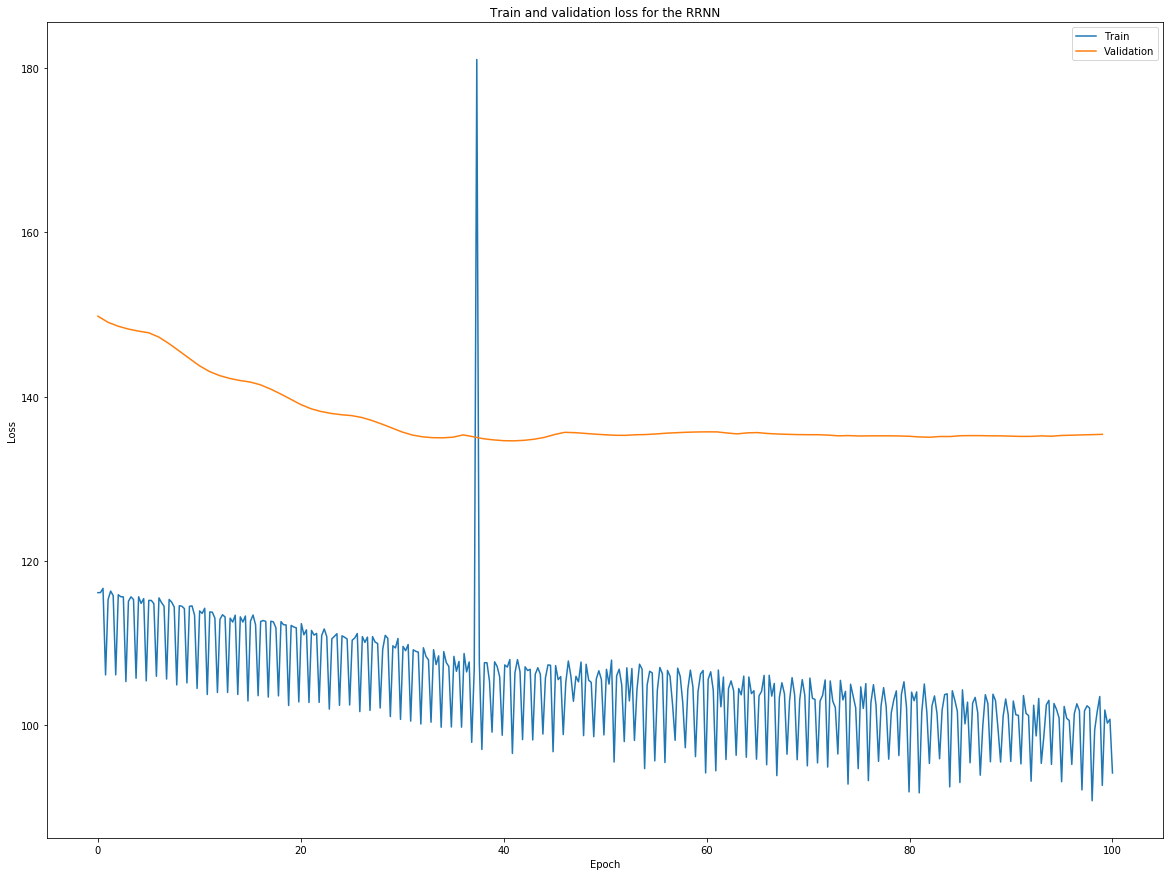

In [55]:
# Plot train and validation loss in the same figure

# Get validation losses
val = []
with open(dirname + '/val_loss.txt', 'r') as f:
    for iteration in f:
        val.append([float(term) for term in iteration.split()])
val_loss = np.array(val)

# Plot
plt.figure(figsize=(20, 15))
plt.plot(x_axis, np.sum(losses, axis=1), label='Train')
# valx = val[:, 0] / n_data # The first column of val is the iteration numbers
# valx = np.linspace(0, batch_size * N_iters / n_data, num=val.shape[0])
plt.plot(range(n_epochs), np.sum(val_loss[:, 1:], axis=1), label='Validation')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and validation loss for the RRNN')
plt.show()

# Next do this for an actual GRU model.


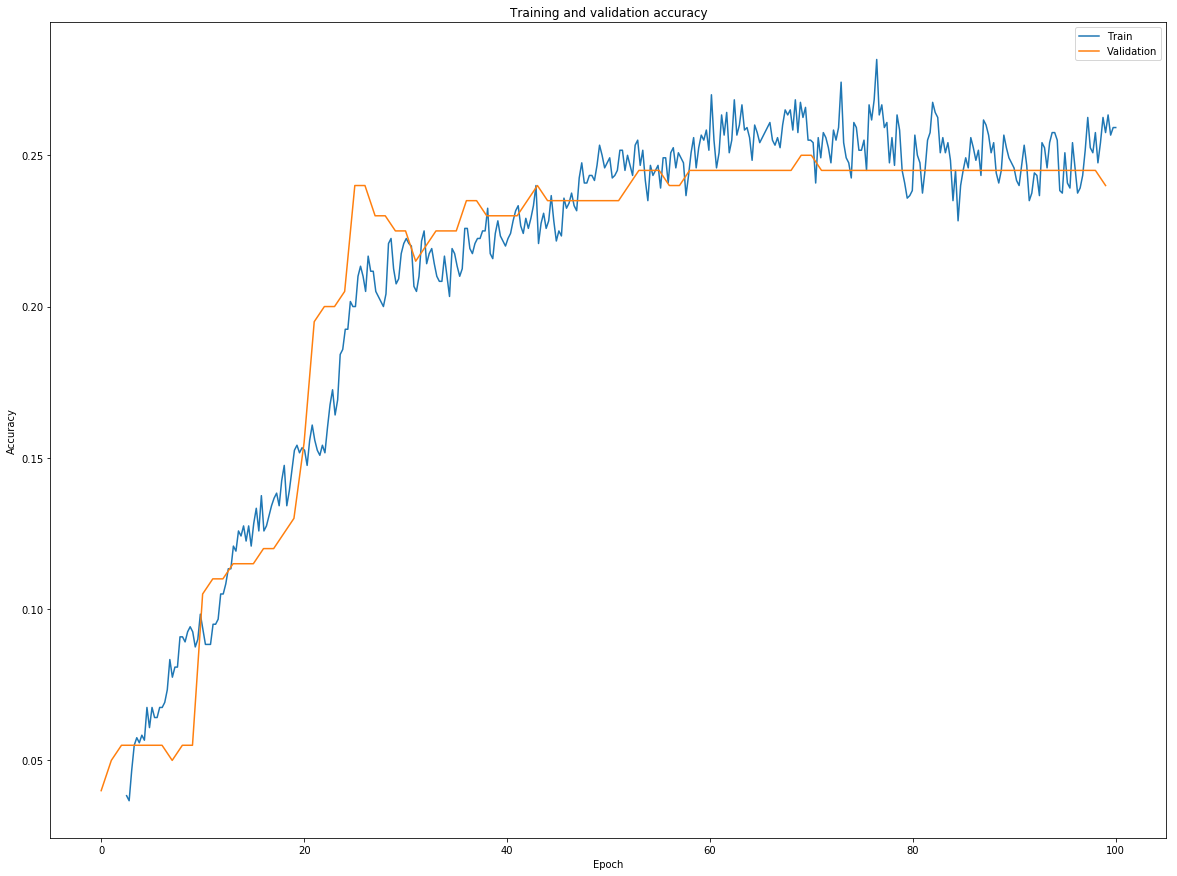

In [58]:
# Training and validation accuracy

if params['nb_val'] > 0:
    val = []
    with open(dirname + '/val_acc.txt', 'r') as f:
        for iteration in f:
            val.append([float(term) for term in iteration.split()])
    val = np.array(val)
else:
    val = np.zeros((2, 2))

# train = []
# with open(dirname + '/train_acc.txt', 'r') as f:
#     for iteration in f:
#         train.append([float(term) for term in iteration.split()])
# train = np.array(train)
train = pickle.load(open(dirname + '/acc_history.pkl', 'rb'))
train = np.array(train)

# Training accuracy here is the average of the last V training examples, 
# where V is the size of the validation set.
val_size = 10
for i in reversed(range(train.shape[0])):
    train[i] = np.mean(train[i-val_size:i])
    
plt.figure(figsize=(20, 15))
plt.plot(x_axis, train, label='Train')
plt.plot(range(n_epochs), val, label='Validation')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()




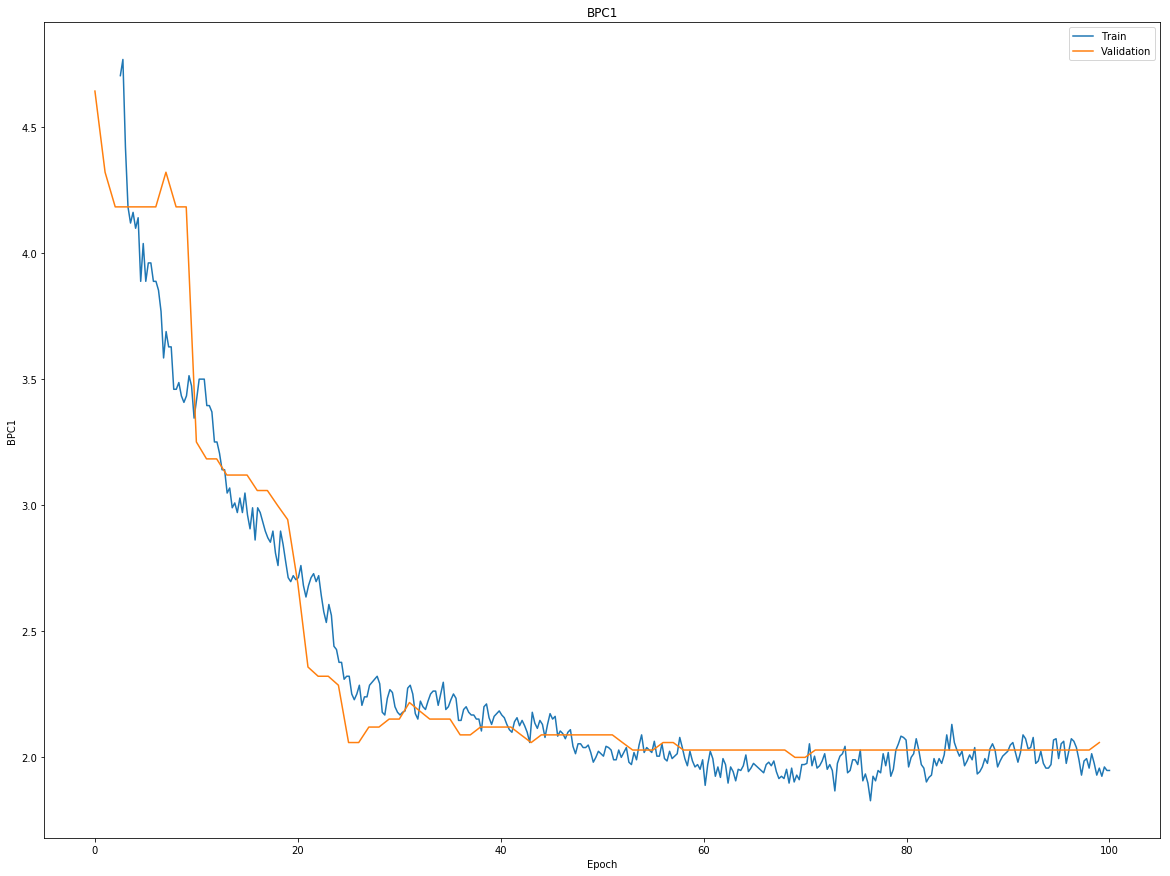

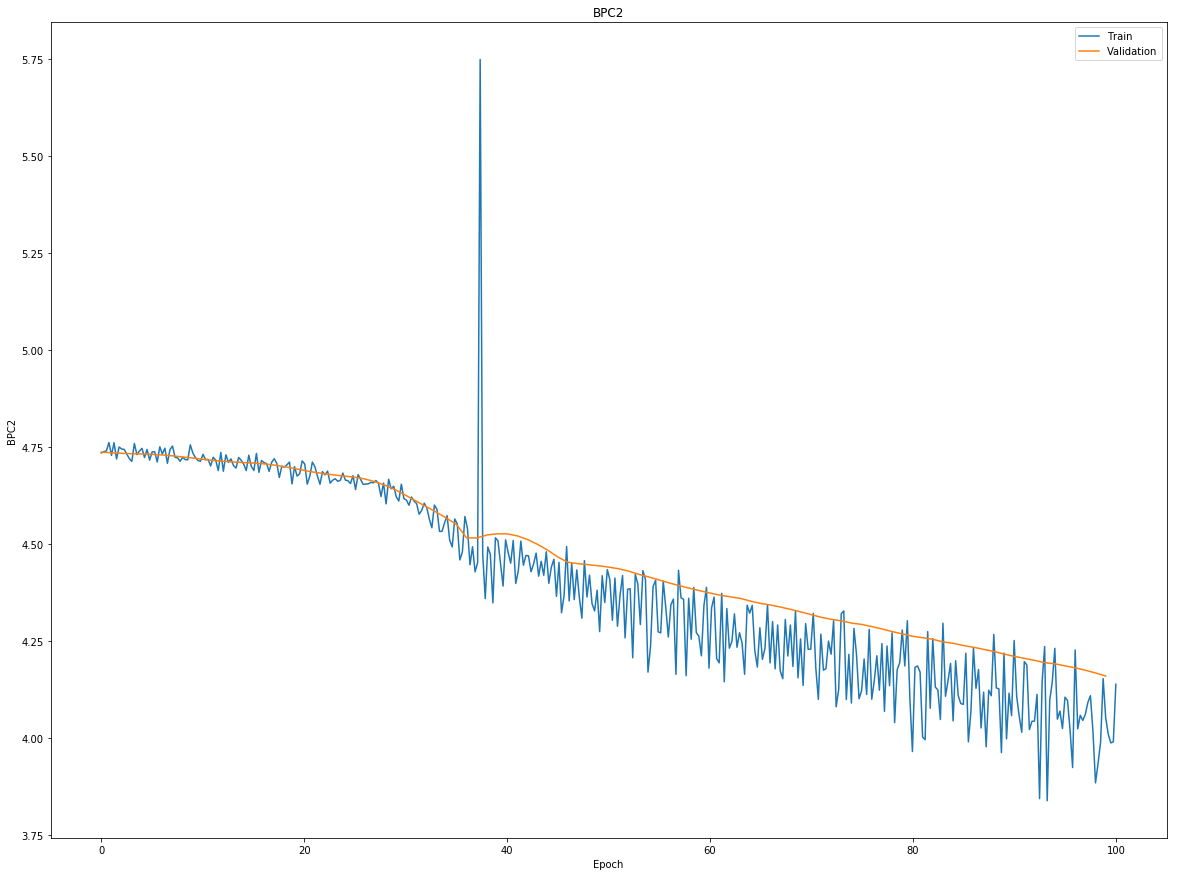

In [59]:
# Plot BPC1 and BPC2

# BPC1 = -log2(accuracy)

eps = 1e-6
train_bpc = -np.log2(train + eps)
val_bpc = -np.log2(val + eps)
plt.figure(figsize=(20, 15))
train_x = np.linspace(0, batch_size * train_bpc.shape[0] / n_data, num=train_bpc.shape[0])
val_x = np.linspace(0, batch_size * N_iters / n_data, num=val_bpc.shape[0])
plt.plot(x_axis, train_bpc, label='Train')
plt.plot(range(n_epochs), val_bpc, label='Validation')
plt.ylabel('BPC1')
plt.xlabel('Epoch')
plt.title('BPC1')
plt.legend()
plt.show()

# BPC2 = loss1 / n_time_steps / ln 2

plt.figure(figsize=(20, 15))
plt.plot(x_axis, losses[:, 0] / 20 / np.log(2), label='Train')
plt.plot(range(n_epochs), val_loss[:, 0] / 20 / np.log(2), label='Validation')
plt.ylabel('BPC2')
plt.xlabel('Epoch')
plt.title('BPC2')
plt.legend()
plt.show()

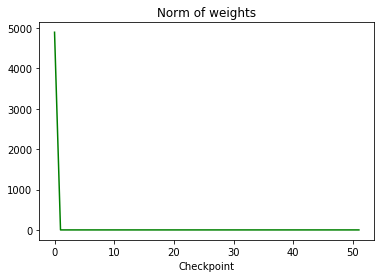

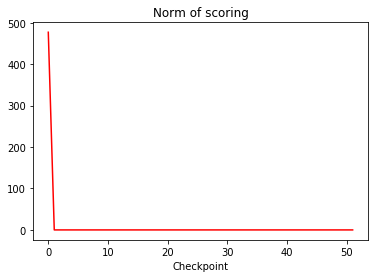

In [ ]:
# Display weight magnitudes

epochs = params['epochs']
checkpoints = []
for file in os.listdir(dirname):
    if '.pt' in file:
        checkpoints.append(file)

checkpoints = [torch.load(dirname + '/' + checkpoint) for checkpoint in sorted(checkpoints)]
magnitudes = np.zeros(len(checkpoints))
scoring = np.zeros(len(checkpoints))
        
for weights in checkpoints:
    for weight in weights:
        magnitudes[i] += weights[weight].norm()
        if 'scoring' in weight:
            scoring[i] += weights[weight].norm()
        

plt.figure()
plt.plot(range(len(magnitudes)), magnitudes, 'g')
plt.title('Norm of weights')
plt.xlabel('Checkpoint')
plt.show()

plt.figure()
plt.plot(range(len(scoring)), scoring, 'r')
plt.title('Norm of scoring')
plt.xlabel('Checkpoint')
plt.show()


In [ ]:
# Show 5 different structures from training

structures = []
with open(dirname+'/structure.txt') as f:
    lines = f.readlines()
    for line in lines:
        if line != '\n':
            structures.append(line)
            
    spacing = 1000
#     for i in range(0, N_iters, spacing):
# #         print('Iteration', i)
# #         print(structures[i])
#         print()
    
    print('Final structure')
    print(structures[-1])

Final structure
[['x', 'h', 0, 'add', 'sigmoid', 'G0'], ['x', 'h', 0, 'add', 'sigmoid', 'G1'], ['x', 'h', 0, 'add', 'sigmoid', 'G2'], ['h', 'G1', 3, 'mul', 'identity', 'G3'], ['x', 'G3', 0, 'add', 'tanh', 'G4'], ['0', 'G0', 3, 'add', 'minus', 'G5'], ['G5', 'G4', 3, 'mul', 'identity', 'G6'], ['h', 'G2', 3, 'mul', 'identity', 'G7'], ['G6', 'G7', 3, 'add', 'identity', 'G8']]



In [ ]:
# Show GRU structures
import ast
from tqdm import tqdm

best = None
fewest_differences = np.Inf
best_iter = 0
for i, structure in enumerate(structures):
    structure = ast.literal_eval(structure)
    if structure_is_gru(structure):
        diffs = n_differences(structure, GRU_STRUCTURE)
        if diffs < fewest_differences:
            best = structure
            fewest_differences = diffs
            best_iter = i

            
if best is None:
    print('No GRU structures found.')
else:
    print('Best structure (%d differences from GRU) achieved on iteration %d' % (fewest_differences, best_iter))
    pprint(best)

In [ ]:
# Look at spikes

start = int(1e5)
loss4 = losses[:, 3]
spikes = np.argsort(loss4[start:])[::-1] + start
rows = spikes * 2 + 1
for row, spike in zip(rows, spikes):
    print(row-2, loss4[spike-1])
    print(row, loss4[spike])
    print(row+2, loss4[spike+1])
